<a href="https://colab.research.google.com/github/zzcn23/ZoeCannprojects.ipynb/blob/main/Zoe_CannU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb
import xarray as xr
import seaborn as sns

I decided to look at voting data again but on a more complex level. I'm delving into how factors like unemployment, median household income, urban status, % of population with bachelors degree, party, and state impact a counties voting turnout.

Using my casual dag, I think education, urban status, income, and unemployment have the most direct link to voting turnout percentage and they all have pretty direct interactions with each other

In [4]:
#have to drop incomplete rows, so that bambi will run
vote = pd.read_csv(
    'https://raw.githubusercontent.com/zzcn23/ZoeCannprojecr.ipynb/refs/heads/main/socioeconomic_voting.csv').dropna()

In [ ]:
vote

,State,County Name,FIPS,Unemployment Rate 2020,County Median Household Income (2021),Urban Influence Code 2013,County Income Percentile Within State (2021),Bachelor's Degree or Higher Percentage (2018-2022),Party,Vote Percentage
0,ALABAMA,AUTAUGA,1001,5.3,66444.0,2.0,0.955224,29.6,REPUBLICAN,71.436802
1,ALABAMA,BALDWIN,1003,6.1,65658.0,2.0,0.940299,32.6,REPUBLICAN,76.171373
2,ALABAMA,BARBOUR,1005,7.7,38649.0,6.0,0.164179,11.9,REPUBLICAN,53.451226
3,ALABAMA,BIBB,1007,7.3,48454.0,1.0,0.611940,10.9,REPUBLICAN,78.426264
4,ALABAMA,BLOUNT,1009,4.5,56894.0,1.0,0.895522,14.7,REPUBLICAN,89.571553
...,...,...,...,...,...,...,...,...,...,...
3110,WYOMING,SWEETWATER,56037,7.5,74677.0,8.0,0.826087,20.0,REPUBLICAN,73.236316
3111,WYOMING,TETON,56039,6.0,102709.0,8.0,1.000000,60.3,DEMOCRAT,66.599040
3112,WYOMING,UINTA,56041,6.4,70162.0,8.0,0.739130,19.1,REPUBLICAN,79.247278
3113,WYOMING,WASHAKIE,56043,5.3,62176.0,11.0,0.391304,21.1,REPUBLICAN,80.481151


I didn't use FIPS because its just a ID # and I didn't use county income percentile in state because I thought that was redundant when looking at the counties from all states.

In [7]:

# Rename columns
vote.rename(columns={"Unemployment Rate 2020": "UR", "County Median Household Income (2021)": "Income", "Urban Influence Code 2013": "Urban","Bachelor's Degree or Higher Percentage (2018-2022)": "Education", "Vote Percentage": "Vote"}, inplace=True)


#scatter plots of variables

array([[<Axes: xlabel='FIPS', ylabel='FIPS'>,
        <Axes: xlabel='UR', ylabel='FIPS'>,
        <Axes: xlabel='Income', ylabel='FIPS'>,
        <Axes: xlabel='Urban', ylabel='FIPS'>,
        <Axes: xlabel='County Income Percentile Within State (2021)', ylabel='FIPS'>,
        <Axes: xlabel='Education', ylabel='FIPS'>,
        <Axes: xlabel='Vote', ylabel='FIPS'>],
       [<Axes: xlabel='FIPS', ylabel='UR'>,
        <Axes: xlabel='UR', ylabel='UR'>,
        <Axes: xlabel='Income', ylabel='UR'>,
        <Axes: xlabel='Urban', ylabel='UR'>,
        <Axes: xlabel='County Income Percentile Within State (2021)', ylabel='UR'>,
        <Axes: xlabel='Education', ylabel='UR'>,
        <Axes: xlabel='Vote', ylabel='UR'>],
       [<Axes: xlabel='FIPS', ylabel='Income'>,
        <Axes: xlabel='UR', ylabel='Income'>,
        <Axes: xlabel='Income', ylabel='Income'>,
        <Axes: xlabel='Urban', ylabel='Income'>,
        <Axes: xlabel='County Income Percentile Within State (2021)', ylabel='Incom

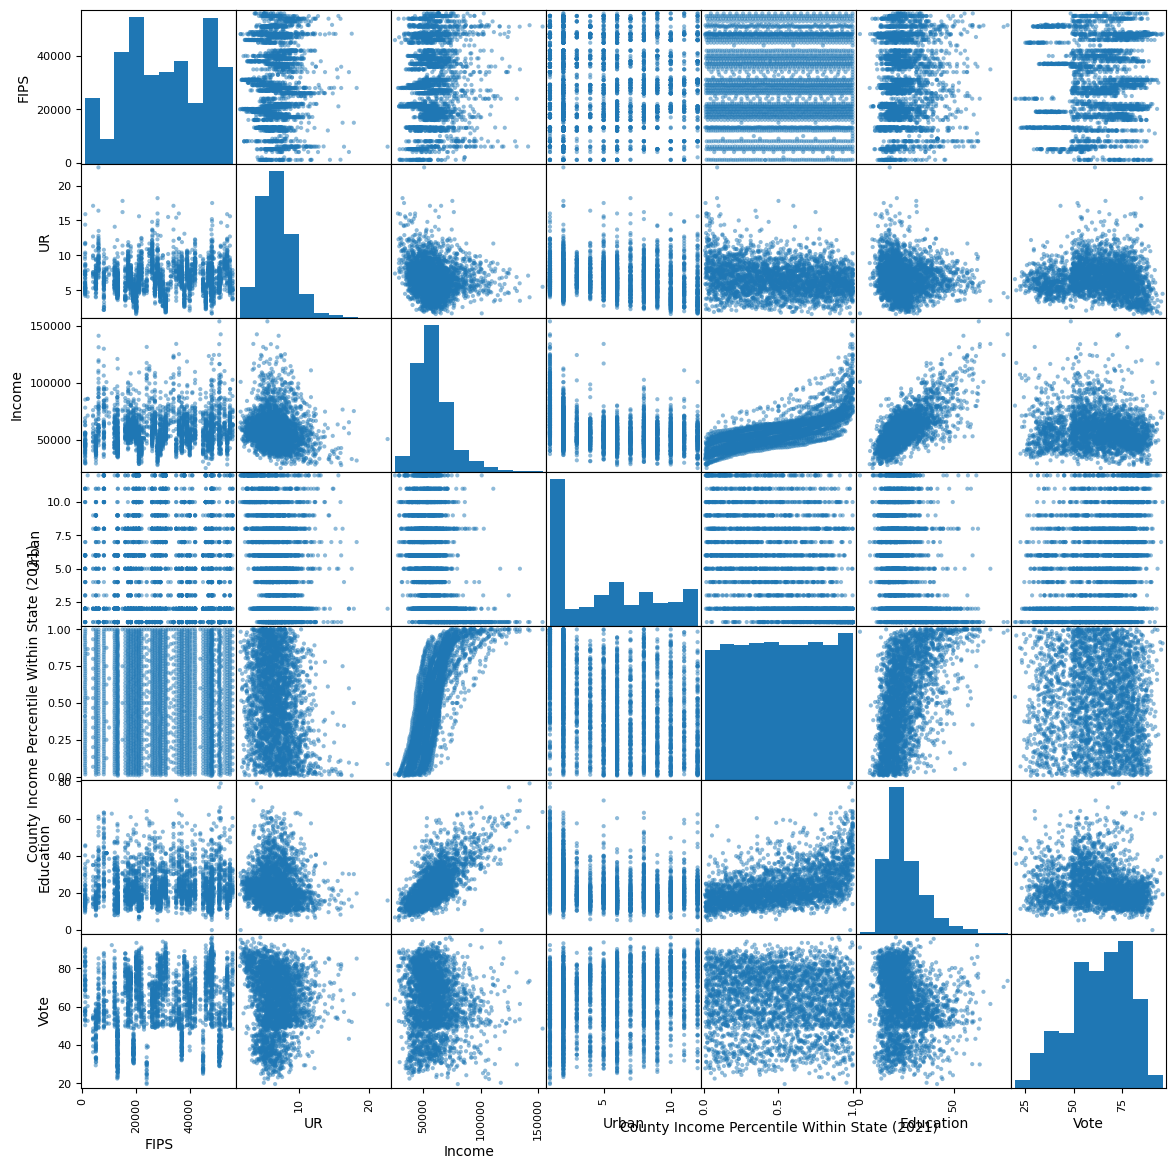

In [ ]:

pd.plotting.scatter_matrix(vote, figsize=(14,14))

From these scatterplots it doesn't look like there are any clear trends between the variables and voting turnout...

#Models based on diagram

This is my reference model, it uses all of the predictors with no interactions.

In [8]:
#define the model
reference = bmb.Model("`Vote` ~ `Party` + 'Education' + 'Urban' + 'Income'+ 'UR'+ State", data=vote)
#fit the model
reference = reference.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


This is my initial best guess model, it uses the variables I think have the most direct correlation with no interactions based on my casual DAG. I think state and party have less direct links to voting turnout because even though democrats typically have higher turnout, there's been less of a trend in recent elections. States also don't have a uniform trend in terms of voting turnout and are just labels.

In [9]:
#define the model
model_vote1 = bmb.Model("`Vote` ~ 'Education' + 'Urban' + 'Income'+ 'UR'", data=vote)
#fit the model
idata_vote1 = model_vote1.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

This is my best guess model but with interactions between all- I think this is the reality

In [10]:
#define the model
model_vote2 = bmb.Model("`Vote` ~ 'Education' + 'Urban' + 'Income'+ 'UR'+`Education`:'Urban' + 'Education':'Income'+ 'Education':'UR'+ 'Urban': 'Income'+ 'Urban':'UR'+'Income':'UR'", data=vote)
#fit the model
idata_vote2 = model_vote2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

#Variables individually

I decided to look at each variable individually to determine if there was a trend between the variable and voting turnout

In [ ]:
#state v voting
model_state = bmb.Model("`Vote` ~ State", data=vote)
#fit the model
idata_state = model_state.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Vote', ylabel='Vote'>], dtype=object))

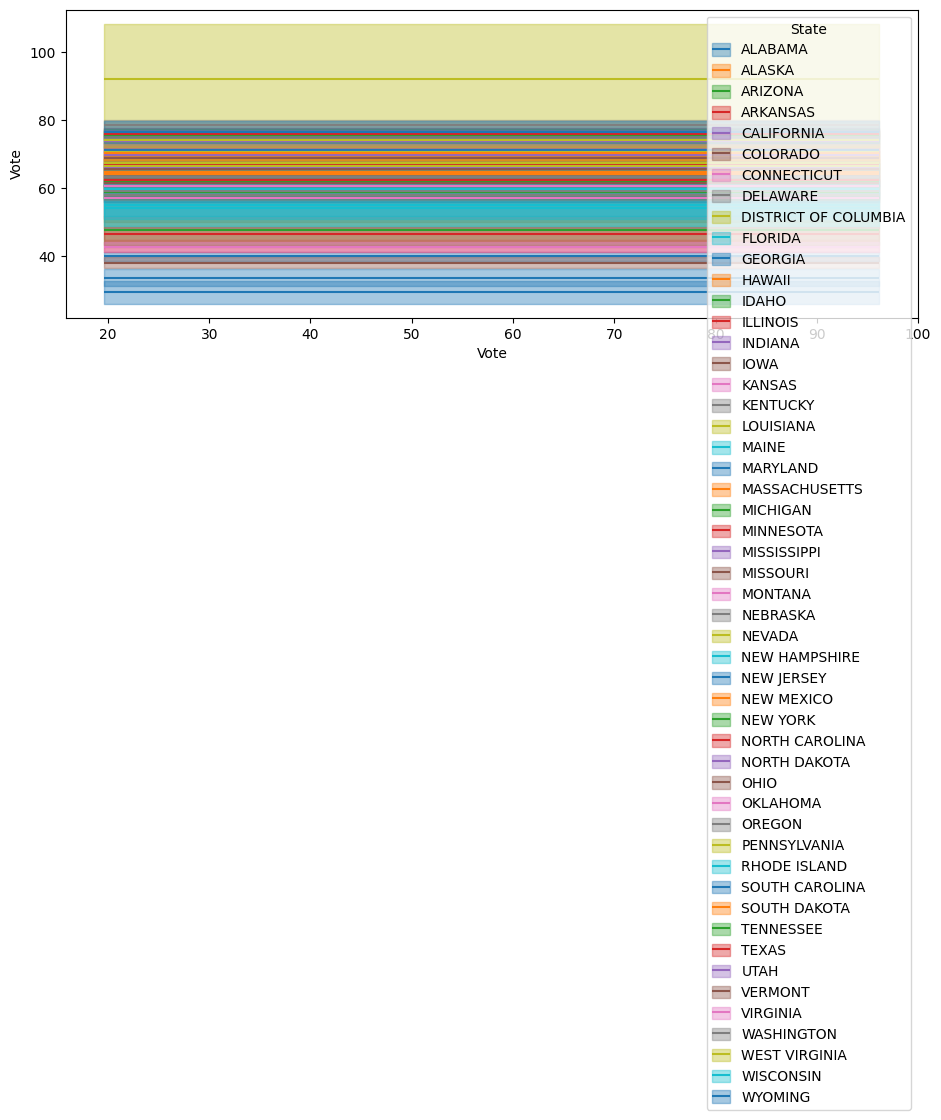

In [ ]:
bmb.interpret.plot_predictions(model_state,
                               idata_state,
                               ["Vote","State"],
                               fig_kwargs={"figsize":(11, 4)})

No trend- slope is 0

In [16]:
#education v voting
model_Education = bmb.Model("`Vote` ~ 'Education' + State", data=vote)
#fit the model
idata_Education = model_Education.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Education', ylabel='Vote'>], dtype=object))

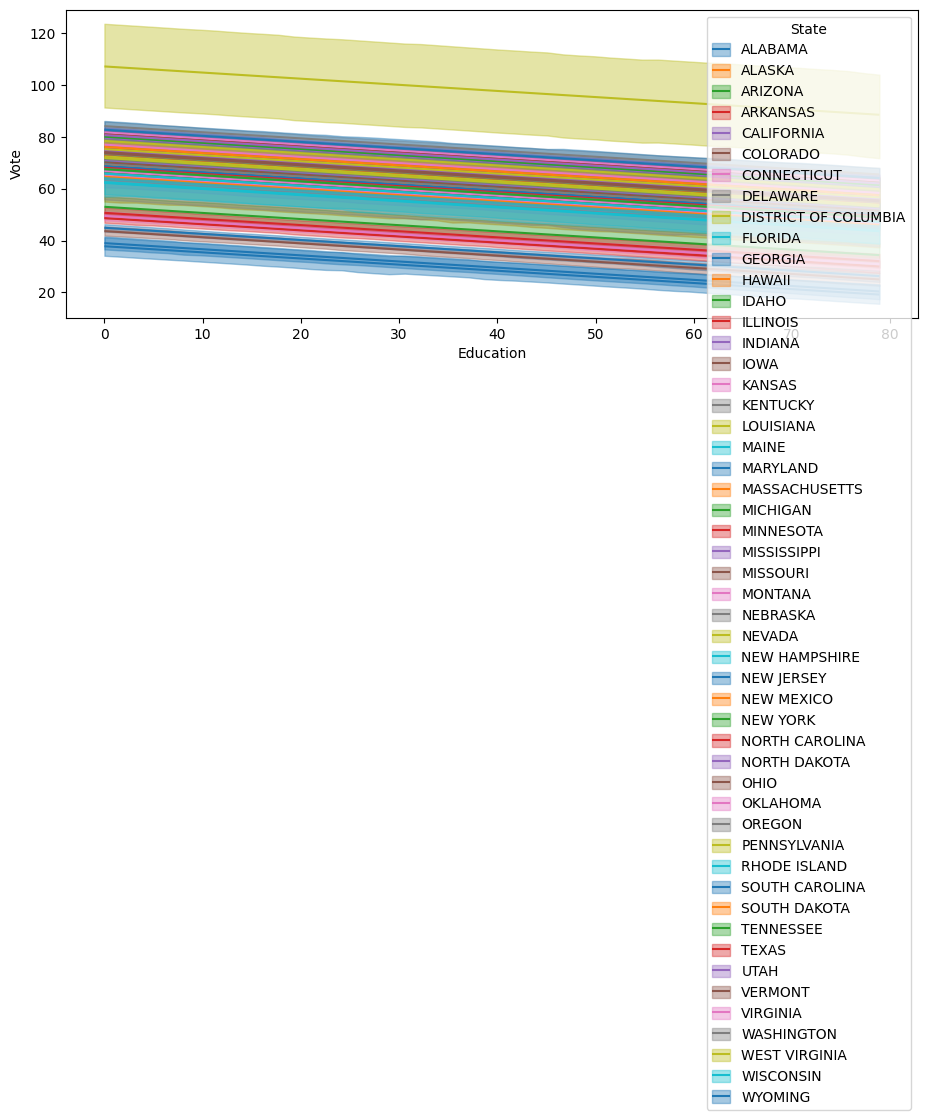

In [ ]:
bmb.interpret.plot_predictions(model_Education,
                               idata_Education,
                               ["Education","State"],
                               fig_kwargs={"figsize":(11, 4)})

The slope is negative, meaning that with more education, there is lower voting turnout

In [ ]:
#define the model, but as a hierarchy
model_Education_h = bmb.Model("`Vote` ~ (`Education`|State)", data=vote)
#create the model
idata_Education_h = model_Education_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Education', ylabel='Vote'>], dtype=object))

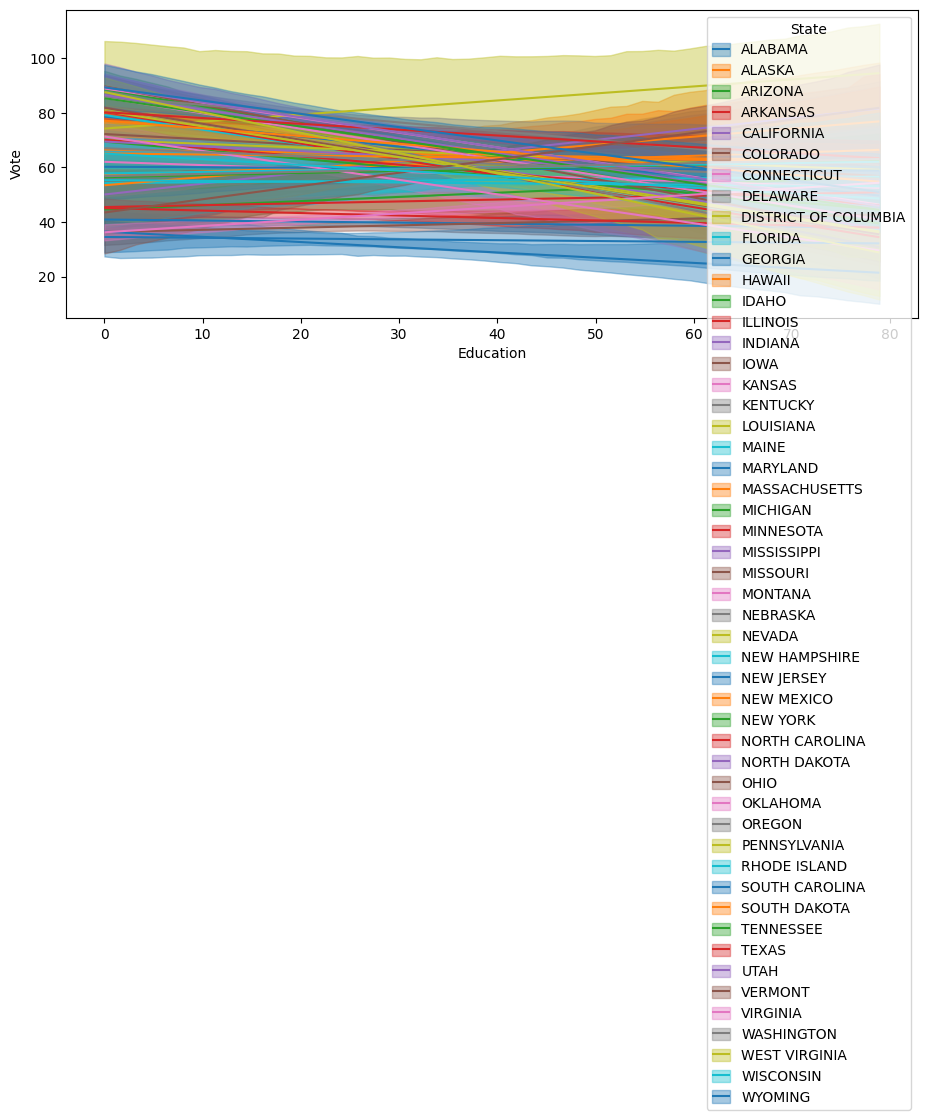

In [ ]:
bmb.interpret.plot_predictions(model_Education_h,
                               idata_Education_h,
                               ["Education","State"],
                               fig_kwargs={"figsize":(11, 4)})

With a hierarchical model it looks like the slopes are all pretty different with some upward and some downward. There's not a uniform clear trend so I think education doesn't have as direct a link to voting turnout as I thought

In [ ]:
#education v voting w interaction
model_Education_inter = bmb.Model("`Vote` ~ `Education` + State + `Education`:State", data=vote)
#create the model
idata_Education_inter = model_Education_inter.fit(idata_kwargs={'log_likelihood': True})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Education', ylabel='Vote'>], dtype=object))

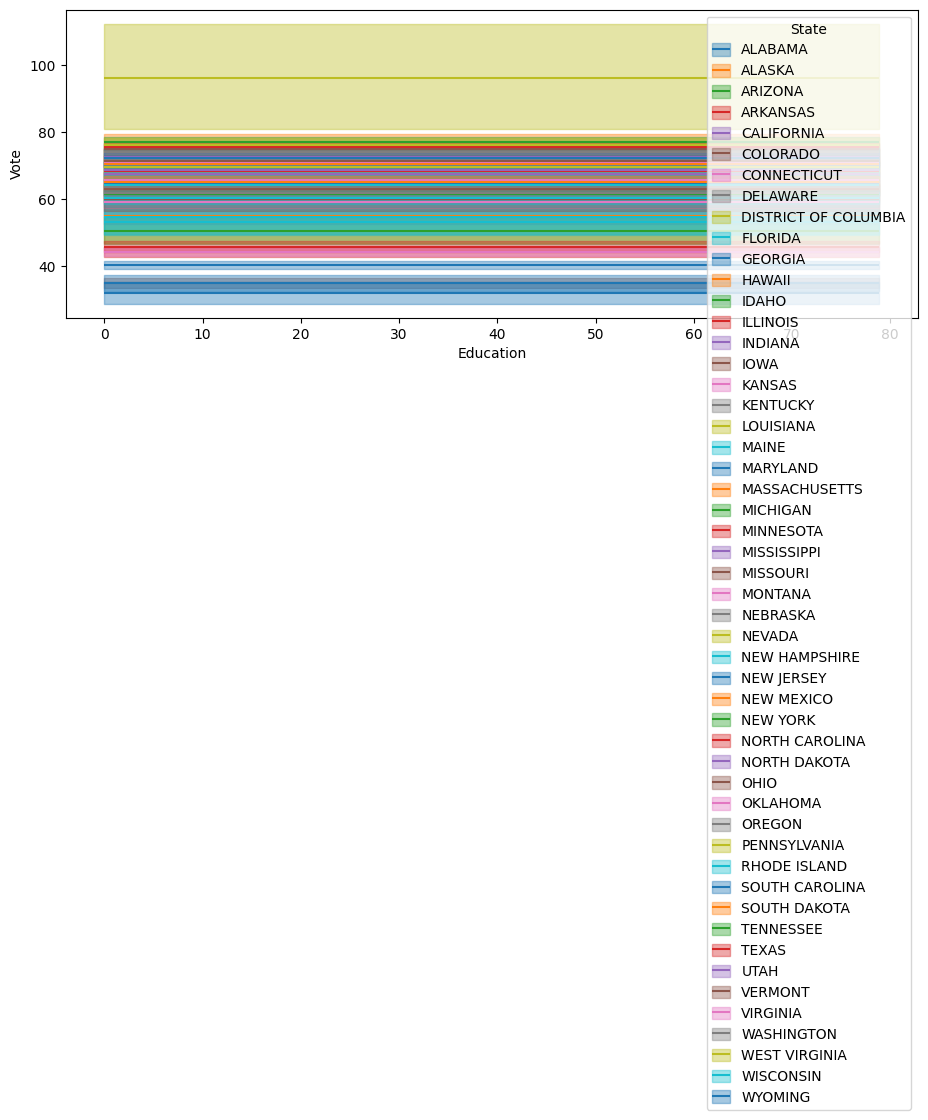

In [ ]:
bmb.interpret.plot_predictions(model_Education_inter,
                               idata_Education_inter,
                               ["Education","State"],
                               fig_kwargs={"figsize":(11, 4)})

There is no slope which means there is no clear correlation, between this and the hierarchical model I think education isn't a good variable to include in my model. This also took an insanly long time to run. The interaction creates too much noise and makes the model worse

In [17]:
#urban v voting
model_Urban = bmb.Model("`Vote` ~ `Urban`+State", data=vote)
#create the model
idata_Urban = model_Urban.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Urban', ylabel='Vote'>], dtype=object))

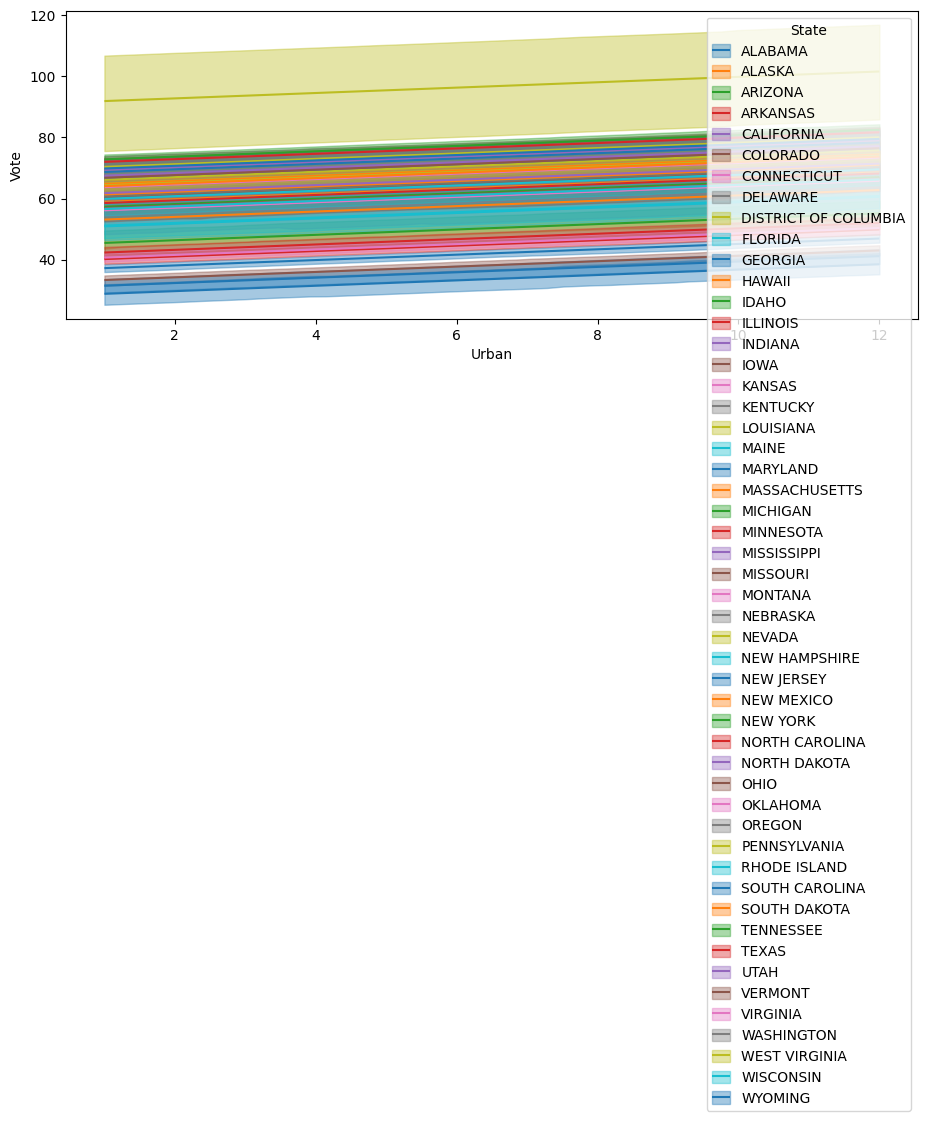

In [ ]:
bmb.interpret.plot_predictions(model_Urban,
                               idata_Urban,
                               ["Urban","State"],
                               fig_kwargs={"figsize":(11, 4)})

There's a slight upward trend, I think the link between more urban and higher voting turnout is relatively direct and clear

In [ ]:
#define the model, but as a hierarchy
model_Urban_h = bmb.Model("`Vote` ~ (`Urban`|State)", data=vote)
#create the model
idata_Urban_h = model_Urban_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Urban', ylabel='Vote'>], dtype=object))

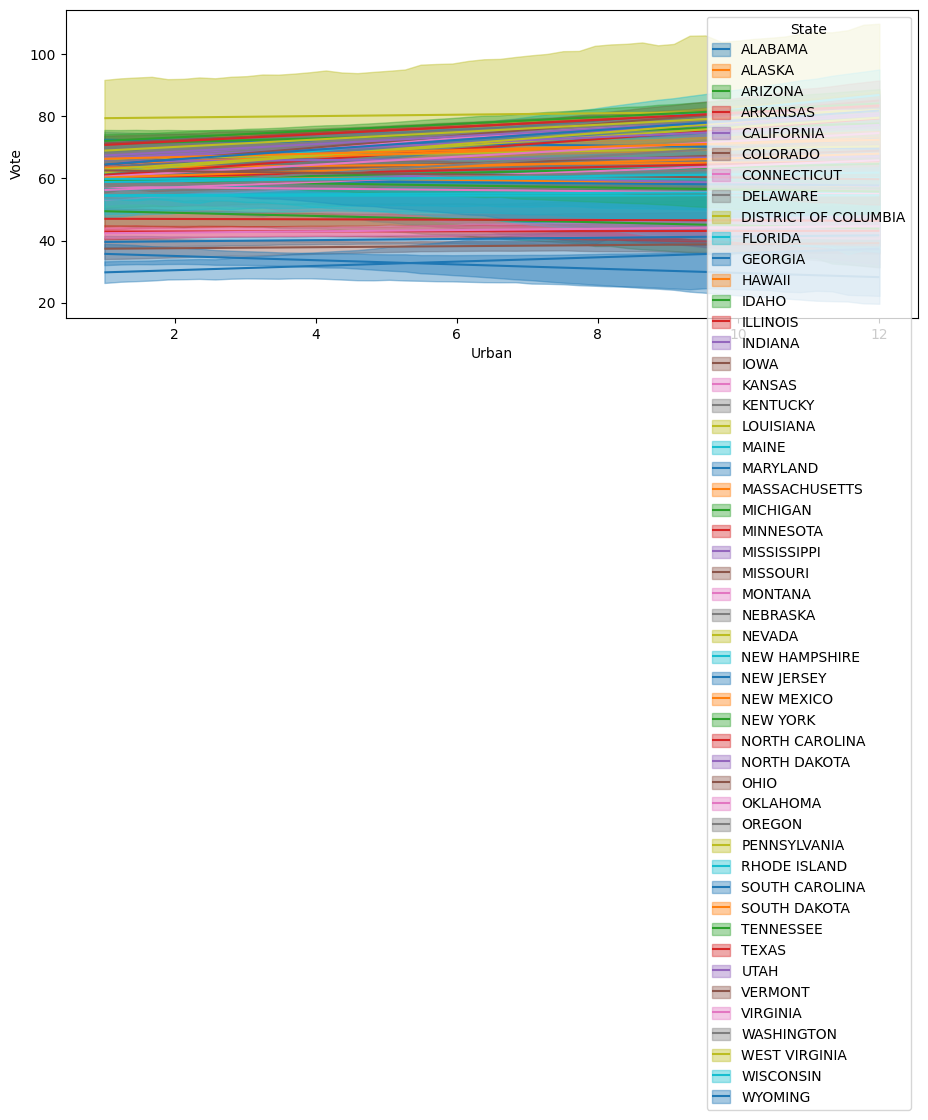

In [ ]:
bmb.interpret.plot_predictions(model_Urban_h,
                               idata_Urban_h,
                               ["Urban","State"],
                               fig_kwargs={"figsize":(11, 4)})

There isn't a clear trend  between Urban location and Voting turnout either when looking at the hierarchical model, sharing information between the categories leads to less of a trend and increased variability as the more Urban you get

In [ ]:
#income v voting turnout
model_Income = bmb.Model("`Vote` ~ `Income`+State", data=vote)
#create the model
idata_Income = model_Income.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Income', ylabel='Vote'>], dtype=object))

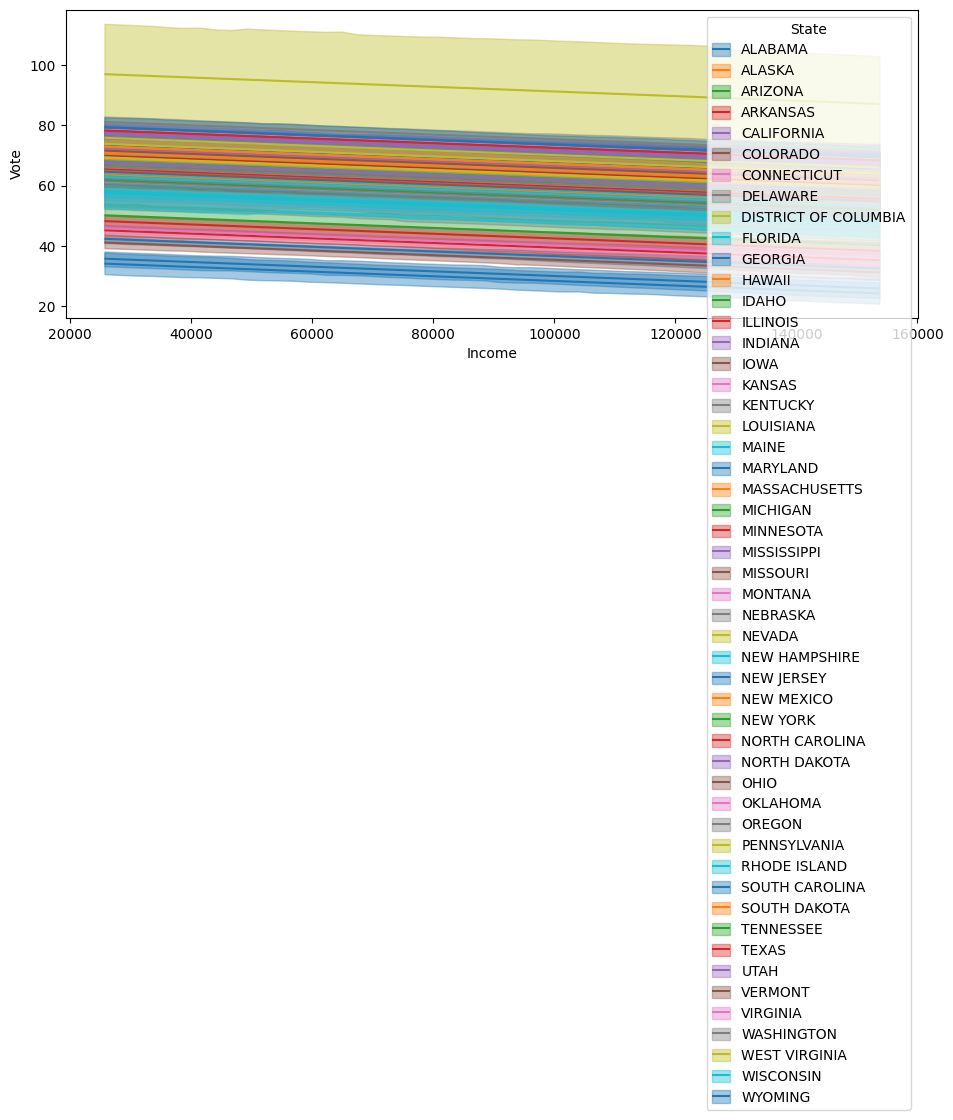

In [ ]:
bmb.interpret.plot_predictions(model_Income,
                               idata_Income,
                               ["Income","State"],
                               fig_kwargs={"figsize":(11, 4)})

Not a strong correlation but there is a downward trend

In [ ]:
#define the model, but as a hierarchy
model_Income_h = bmb.Model("`Vote` ~ (`Income`|State)", data=vote)
#create the model
idata_Income_h = model_Income_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Income', ylabel='Vote'>], dtype=object))

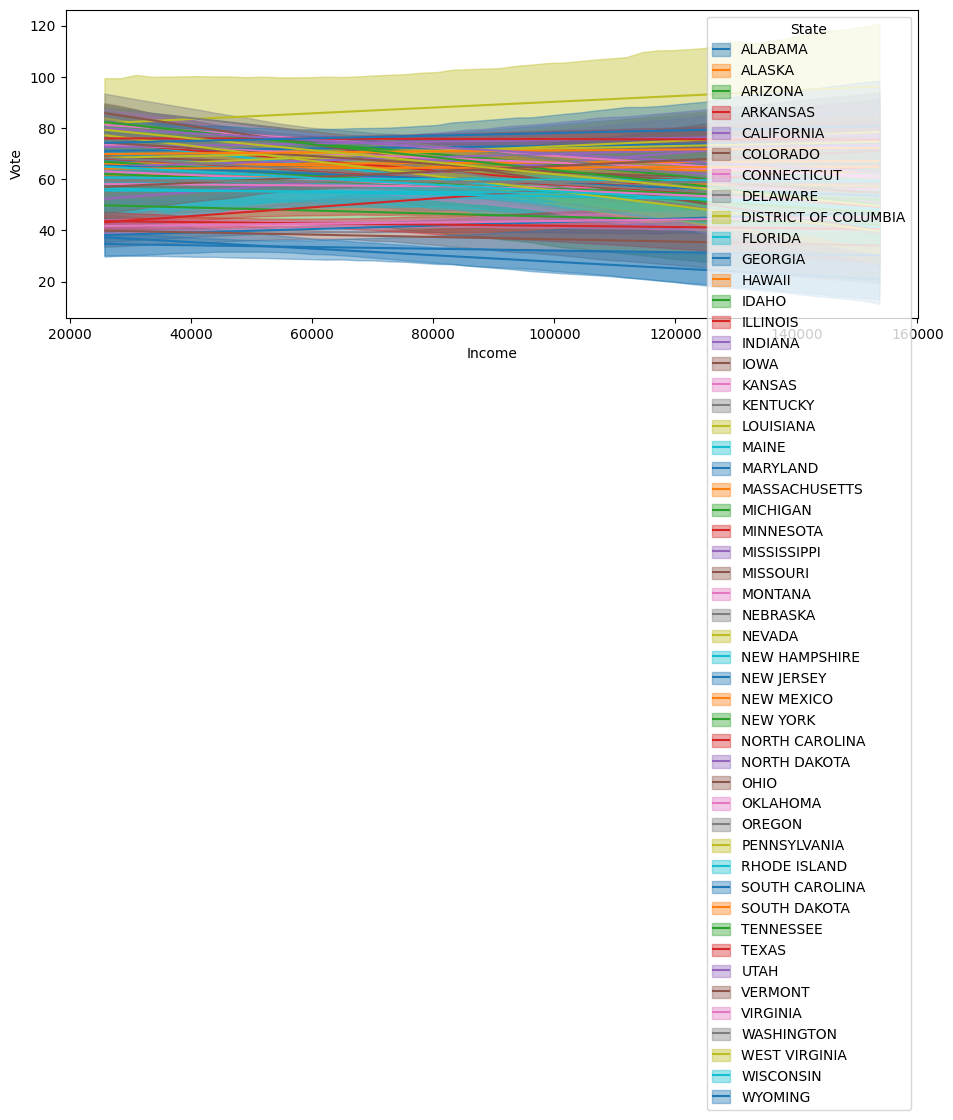

In [ ]:
bmb.interpret.plot_predictions(model_Income_h,
                               idata_Income_h,
                               ["Income","State"],
                               fig_kwargs={"figsize":(11, 4)})

Same thing as other variables, no longer a trend when made a hierarchical model

In [ ]:
#unemployment and voting turnourt
model_UR = bmb.Model("`Vote` ~ `UR`+ State", data=vote)
#create the model
idata_UR = model_UR.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='UR', ylabel='Vote'>], dtype=object))

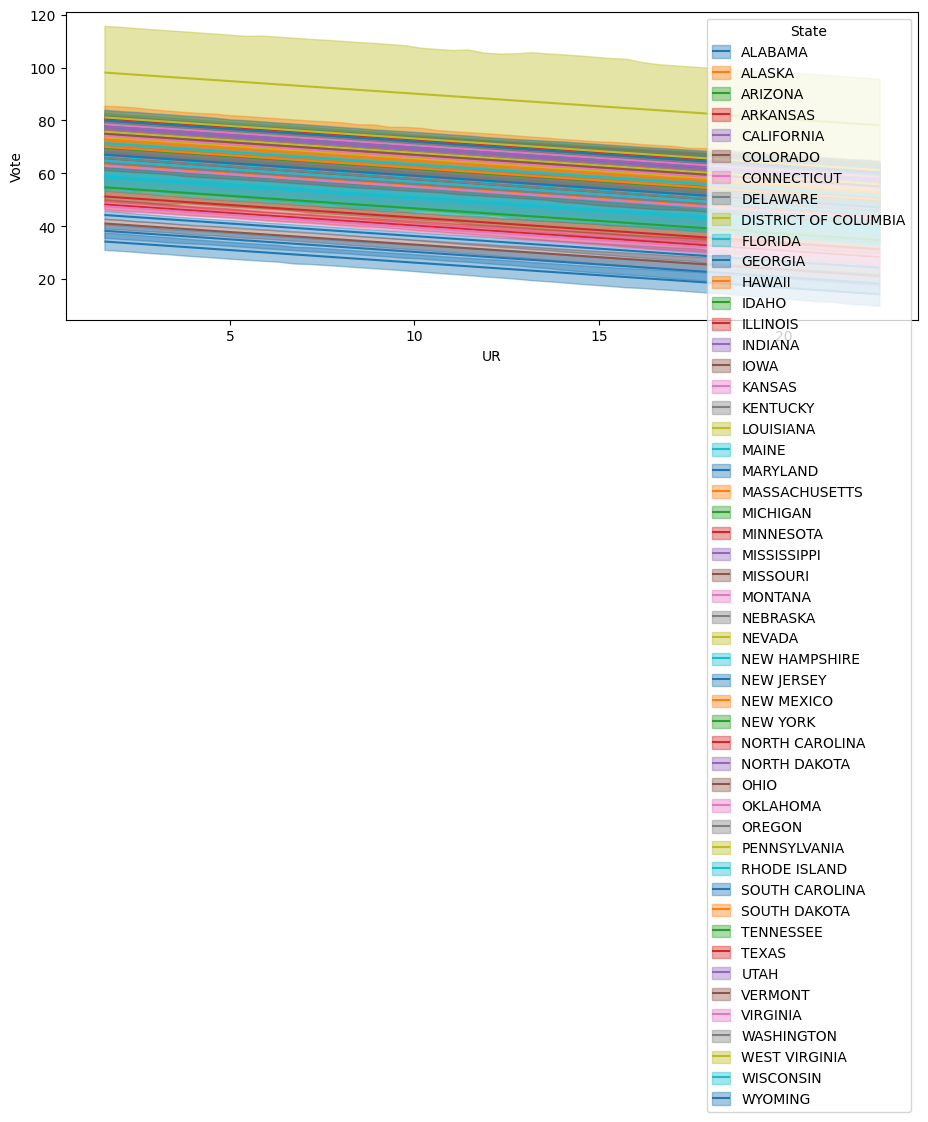

In [ ]:
bmb.interpret.plot_predictions(model_UR,
                               idata_UR,
                               ["UR","State"],
                               fig_kwargs={"figsize":(11, 4)})

There is more variability in voting turnout as unemployment increases but it does look like there is a downward trend

In [ ]:
#unemployment and voting turnourt
model_Party = bmb.Model("`Vote` ~ `Party`+ State", data=vote)
#create the model
idata_Party = model_Party.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Party', ylabel='Vote'>], dtype=object))

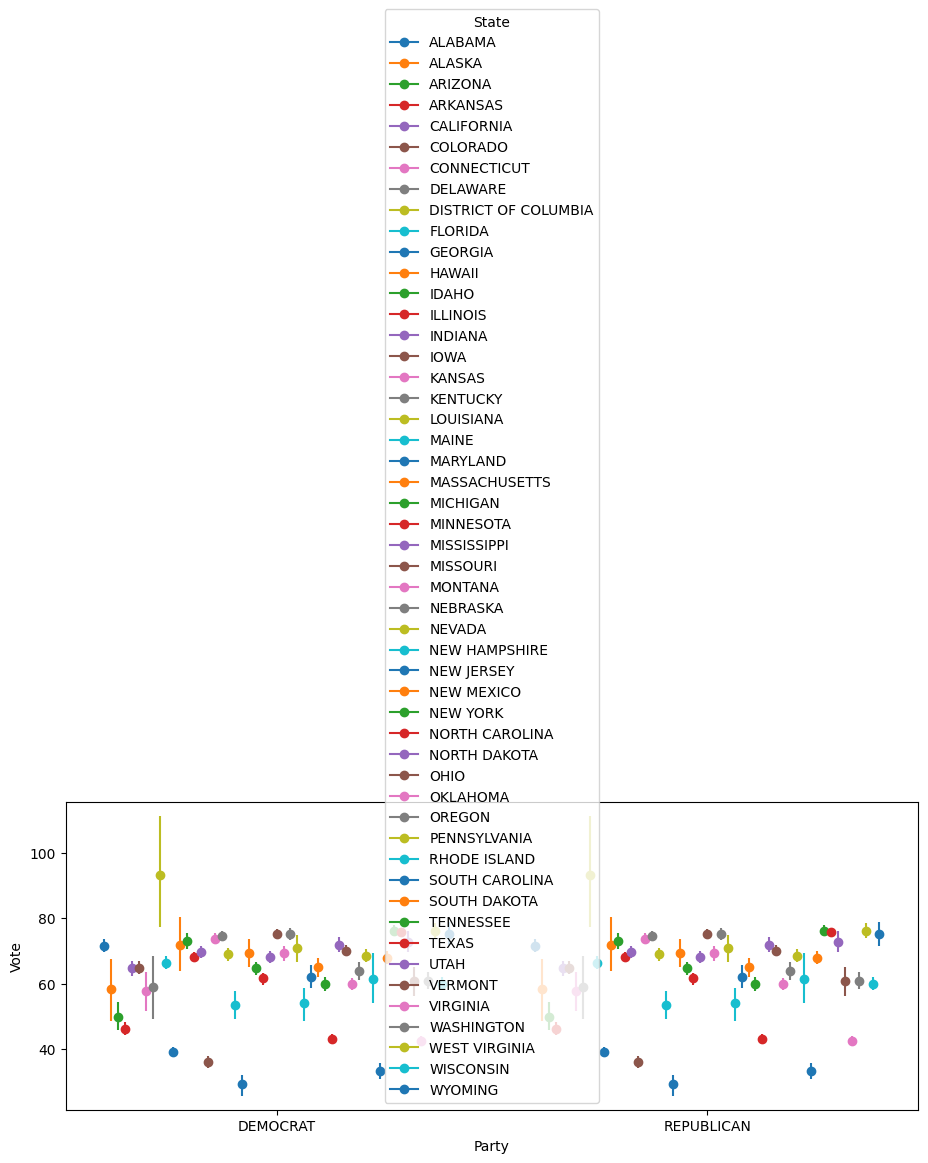

In [ ]:
bmb.interpret.plot_predictions(model_UR,
                               idata_UR,
                               ["Party","State"],
                               fig_kwargs={"figsize":(11, 4)})

#compare


In [ ]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"1": reference,"2":idata_Education, "3":idata_Income,"4":idata_UR, "5":idata_Urban, "6": idata_Party} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
1,0,-10989.450118,59.459188,0.000000,8.560476e-01,47.001880,0.000000,True,log
5,1,-11107.856776,49.555143,118.406658,5.140908e-11,42.050260,21.962154,True,log
2,2,-11168.109982,51.109001,178.659863,6.181535e-11,44.166958,23.046319,True,log
7,3,-11175.789071,49.798315,186.338953,7.285230e-11,40.733464,23.673699,True,log
4,4,-11206.354400,48.906029,216.904282,6.565168e-02,40.100518,27.217061,True,log
3,5,-11238.781827,49.443507,249.331709,7.830074e-02,40.895236,28.841486,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

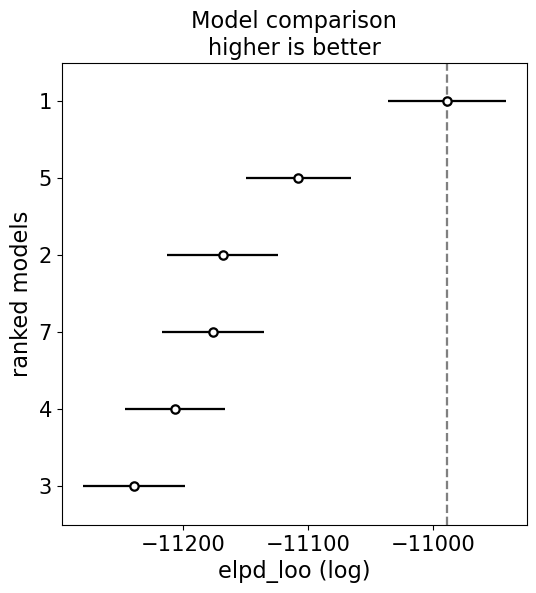

In [ ]:
az.plot_compare(cmp_df)

This is interesting, the graph tells us that although none of the single variables beat the reference (all the variables), the urban one was the closest and then education and party

#multi variable models

Since the interaction models failed, I'm trying to do some multi variables ones with no interactions based on the single variable ones that did the best

In [11]:
#define the model
model_vote_multi1 = bmb.Model("`Vote` ~ `Urban` + 'Education'", data=vote)
#create the model
idata_vote_multi1 = model_vote_multi1.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [12]:
#define the model
model_vote_multi2 = bmb.Model("`Vote` ~ `Urban` + 'Education' +'Party'", data=vote)
#create the model
idata_vote_multi2 = model_vote_multi2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [13]:
#define the model
model_vote_multi3 = bmb.Model("`Vote` ~ `Urban` + 'UR'+'Education'", data=vote)
#create the model
idata_vote_multi3 = model_vote_multi3.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [14]:
#define the model
model_vote_multi4 = bmb.Model("`Vote` ~ `Urban` +'Party'", data=vote)
#create the model
idata_vote_multi4 = model_vote_multi4.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

Now I'm comparing the multivariable models to the best single model ones and the reference one.

In [18]:
#cmp_df stands for compare dataframe
cmp_df2 = az.compare( {"1": reference,"2":idata_Education, "3":idata_Urban, "4": idata_vote_multi1, "5": idata_vote_multi2, "6":idata_vote_multi3, "7":idata_vote_multi4} )

#0 is the best rank; we want a lower elpd_loo
cmp_df2

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
1,0,-10988.590191,58.478437,0.000000,8.681608e-01,46.915786,0.000000,True,log
3,1,-11106.773765,48.311766,118.183574,7.785488e-02,41.962470,21.975899,True,log
2,2,-11168.114087,50.999565,179.523896,4.045346e-02,44.128098,23.077388,True,log
7,3,-12778.285265,3.614829,1789.695074,1.353091e-02,37.012205,53.293648,False,log
5,4,-12778.665646,4.892198,1790.075455,1.110703e-11,37.198055,53.221912,False,log
6,5,-12824.413852,4.704076,1835.823661,1.076156e-11,37.108955,53.891109,False,log
4,6,-12827.565068,3.667379,1838.974878,0.000000e+00,36.658498,53.881777,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

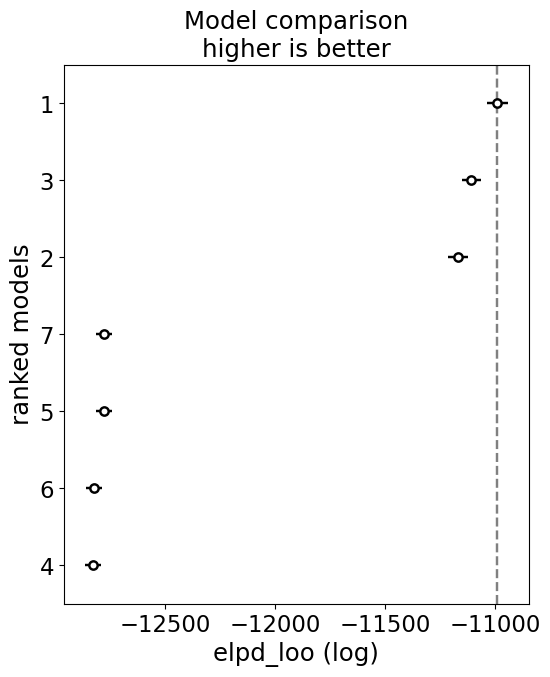

In [19]:
az.plot_compare(cmp_df2)

So the multi variable ones are actually worse than the single variable and reference one. I think this is because the predictors are so complex that different combinations have too much noise and fail.

#Interactions

I'm going to test the two best single variables together with an interaction

In [21]:
#define the model; bb_inter stands for baskeball interaction
model_vote_inter2 = bmb.Model("`Vote` ~ `Urban` + 'Education'+ `Urban`:'Education'", data=vote)
#create the model
idata_vote_inter2 = model_vote_inter2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

Next I decided to try urban and UR and education with an interaction between urban and unemployment. did this because Urban location and unemployment looked like they had somewhat of a trend with voting turnout as opposed to education and income. I also think there is an interaction between urban location and unemployment because the more urban you get, the higher unemployment rates usually are.

In [22]:
#define the model; bb_inter stands for baskeball interaction
model_vote_inter3 = bmb.Model("`Vote` ~ `Urban` + 'UR'+ 'Education'+`Urban`:'UR'", data=vote)
#create the model
idata_vote_inter3 = model_vote_inter3.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [23]:
#cmp_df stands for compare dataframe
cmp_df3 = az.compare( {"1": reference, "2": idata_vote_multi1, "3": idata_vote_multi2, "4":idata_vote_multi4, "5":idata_vote_inter2, "6": idata_vote_inter3})

#0 is the best rank; we want a lower elpd_loo
cmp_df3

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
1,0,-10988.590191,58.478437,0.000000,9.762772e-01,46.915786,0.000000,True,log
4,1,-12778.285265,3.614829,1789.695074,9.948787e-13,37.012205,53.293648,False,log
3,2,-12778.665646,4.892198,1790.075455,0.000000e+00,37.198055,53.221912,False,log
6,3,-12799.277190,5.558160,1810.686999,2.372277e-02,37.296491,54.363781,False,log
2,4,-12827.565068,3.667379,1838.974878,4.686526e-13,36.658498,53.881777,False,log
5,5,-12828.636800,4.782967,1840.046609,0.000000e+00,36.662702,53.836276,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

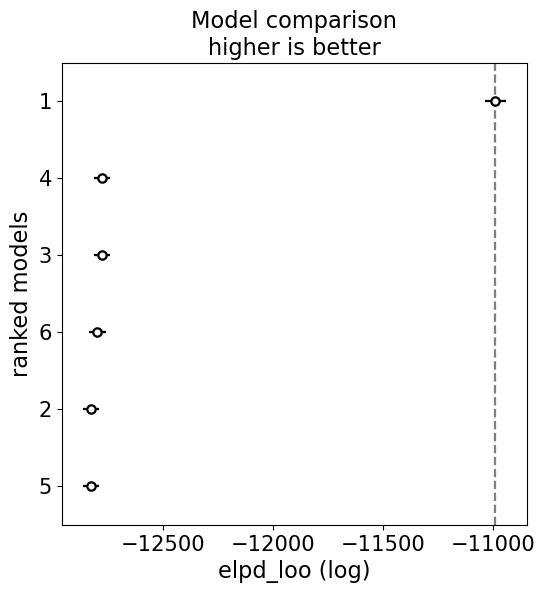

In [24]:
az.plot_compare(cmp_df3)

None of the interaction models come close to beating the reference model and the multivariable ones still do better.

The conclusion is that the reference model that uses all of the variables with no interactions is the best model. Adding interactions or hierarchys creates too much noise because of the too complex variables that interact in so many ways. More variables was worse than less except in the case of all because they helped predict voting turnout comprehensively. The good news is my casual DAG supports the final model because I guessed that all the predictors influenced voting turnout. I was wrong about the variables interacting with each other though, as it created a worse model.